<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/02_baseline_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline Model Training
In this notebook, we load the engineered dataset and train a baseline Logistic Regression model. We use class weights to handle the 22% default rate imbalance, ensuring the model is penalized appropriately for missing potential defaulters.

Mounted at /content/drive
Loading engineered datasets from Google Drive...
✅ Data loaded successfully!
Training Leakage-Safe Pipeline with 5-Fold CV...
✅ Model trained, tuned, and saved successfully!
ROC-AUC: 0.7490


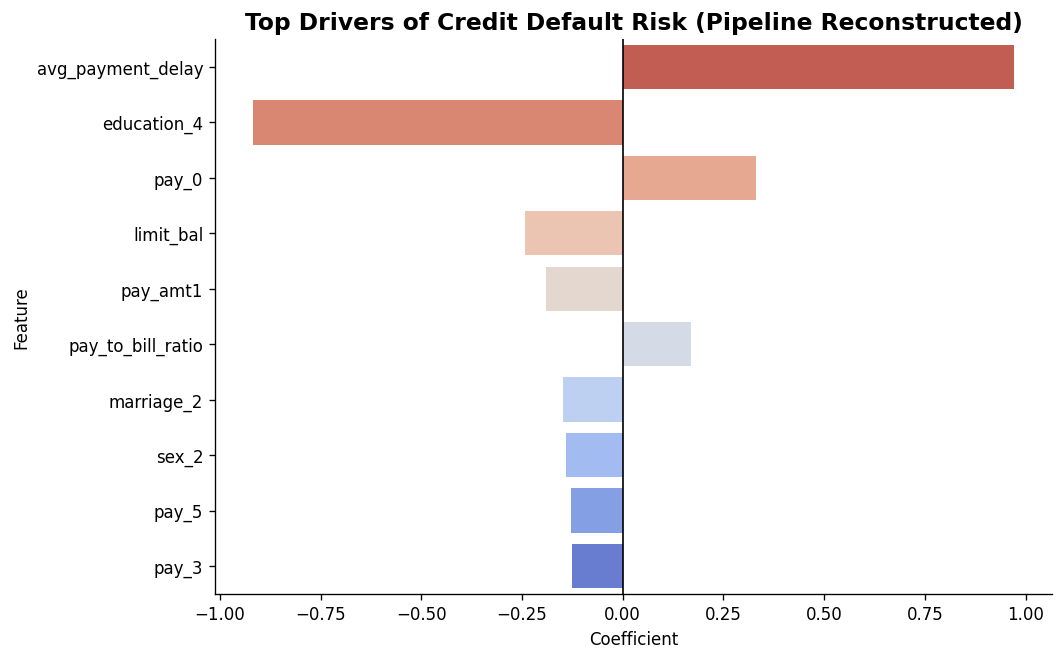

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.family': 'sans-serif', 'axes.titlesize': 14, 'axes.titleweight': 'bold', 'figure.dpi': 120})
sns.set_palette(["#20B2AA", "#DC143C"])

from google.colab import drive
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load the datasets directly from Drive
project_path = '/content/drive/MyDrive/Ahmed Intelligence/AI for Banking and Fintech'
print("Loading engineered datasets from Google Drive...")

train_data = pd.read_csv(f'{project_path}/train_processed.csv')
test_data = pd.read_csv(f'{project_path}/test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

print("✅ Data loaded successfully!")

# 2. Define Leakage-Safe Preprocessing Pipeline
categorical_cols = ['sex', 'education', 'marriage']
continuous_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Handles NaNs correctly
        ('scaler', StandardScaler())
    ]), continuous_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), categorical_cols)
])

# 3. Create Full Pipeline with CV Tuning
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        class_weight='balanced', cv=5, scoring='roc_auc', random_state=42, max_iter=1000
    ))
])

# 4. Train and Save Model
print("Training Leakage-Safe Pipeline with 5-Fold CV...")
baseline_pipeline.fit(X_train, y_train)
joblib.dump(baseline_pipeline, 'baseline_model_pipeline.pkl')
print("✅ Model trained, tuned, and saved successfully!")

# 5. Evaluate & Cost Curve (Same logic as before)
y_pred_prob = baseline_pipeline.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# --- 6. Explainability with Feature Name Reconstruction ---
# Pipelines hide feature names, so we must extract them dynamically
cat_encoder = baseline_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = continuous_cols + list(cat_features)

coefficients = baseline_pipeline.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

plt.figure(figsize=(9, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette="coolwarm_r")
plt.title('Top Drivers of Credit Default Risk (Pipeline Reconstructed)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
sns.despine()
plt.show()

## Model Evaluation and Cost-Aware Decision Threshold Tuning
Because of the class imbalance, standard accuracy is misleading. We evaluate the model using ROC-AUC and PR-AUC, prioritizing the precision and recall of the default class.

The cost of approving a loan that defaults (False Negative) is significantly higher than rejecting a good customer (False Positive). We simulate a business cost matrix to identify the probability threshold that minimizes total portfolio loss.

Evaluation Metrics (Threshold = 0.50)
ROC-AUC Score: 0.7490
PR-AUC Score:  0.5075



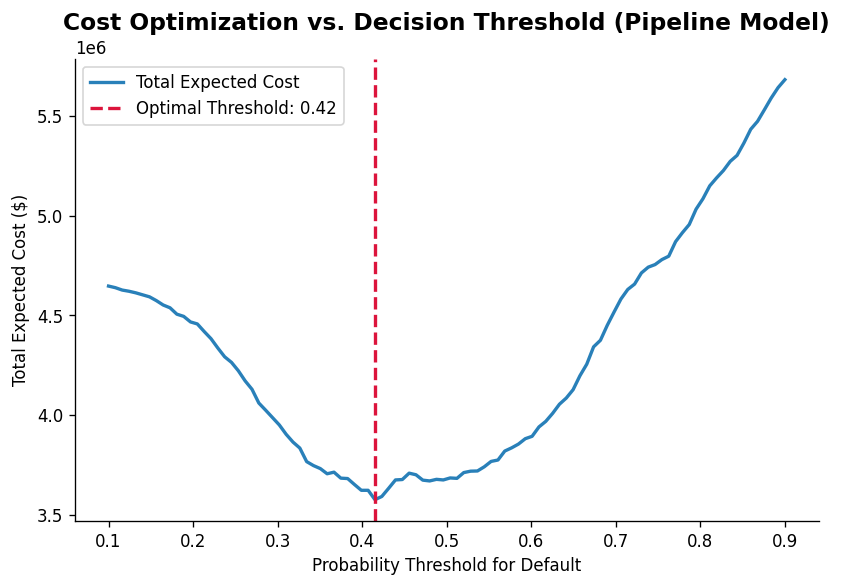

Optimal decision threshold identified at: 0.42


In [3]:
# Generate probability predictions using the new pipeline
y_pred_prob = baseline_pipeline.predict_proba(X_test)[:, 1]

# 1. Standard Metrics
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print("Evaluation Metrics (Threshold = 0.50)")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score:  {pr_auc:.4f}\n")

# 2. Cost-Aware Decision Threshold Tuning
cost_fn = 5000  # Financial loss from a default
cost_fp = 1000  # Opportunity loss from rejecting a good customer

thresholds = np.linspace(0.1, 0.9, 100)
costs = []

for t in thresholds:
    y_pred_t = (y_pred_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

# 3. Visualize the Cost Curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, lw=2, color='#2980B9', label='Total Expected Cost')
plt.axvline(optimal_threshold, color='#DC143C', linestyle='--', lw=2,
            label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.title('Cost Optimization vs. Decision Threshold (Pipeline Model)')
plt.xlabel('Probability Threshold for Default')
plt.ylabel('Total Expected Cost ($)')
plt.legend()
sns.despine()
plt.show()

print(f"Optimal decision threshold identified at: {optimal_threshold:.2f}")

# Model Explainability
To satisfy regulatory requirements and build trust with business stakeholders, we extract the logistic regression coefficients to interpret the drivers of default risk.

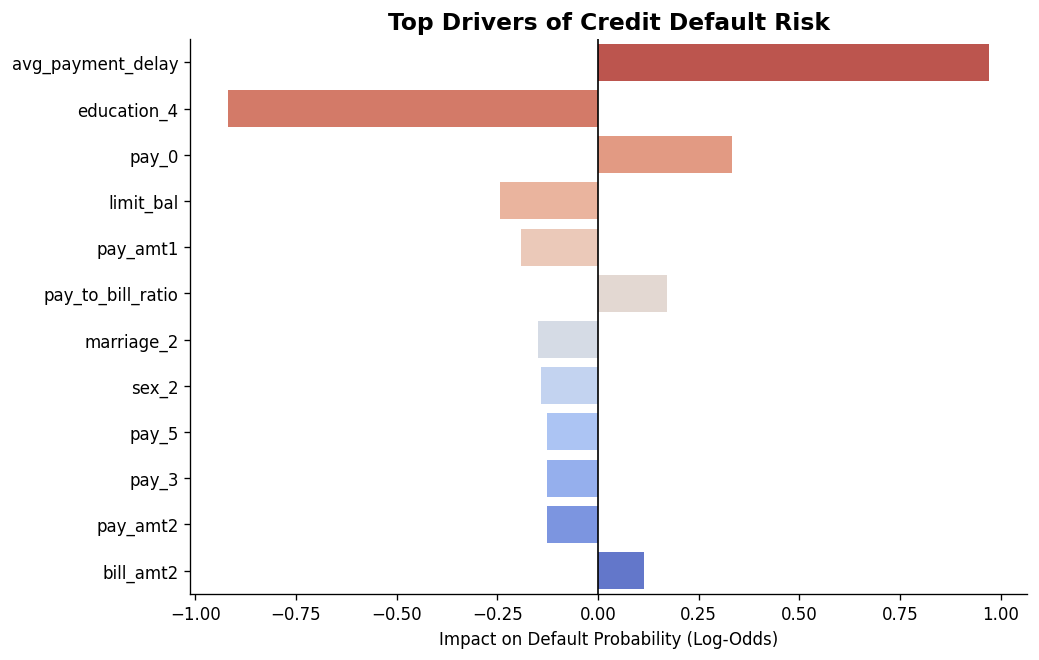

In [4]:
# 1. Reconstruct Feature Names from the Pipeline
# Get the OneHotEncoder step from the categorical pipeline
cat_encoder = baseline_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)

# Combine continuous columns (which weren't renamed) with the new encoded categorical columns
# Note: The order must match how we built the ColumnTransformer (num first, then cat)
all_feature_names = continuous_cols + list(cat_features)

# 2. Extract Coefficients from the LogisticRegressionCV step
coefficients = baseline_pipeline.named_steps['classifier'].coef_[0]

# 3. Create DataFrame and Plot
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(12)

# Visualize Feature Importance
plt.figure(figsize=(9, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette="coolwarm_r")

plt.title('Top Drivers of Credit Default Risk')
plt.xlabel('Impact on Default Probability (Log-Odds)')
plt.ylabel('')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

sns.despine()
plt.show()